## Load our own descriptors from the Lakh Dataset and perform Classification with scikit-learn




In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
# import librosa
import mir_eval
import mir_eval.display
import tables
import IPython.display
import os
import json
from tqdm import tqdm
import pickle

# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = 'results'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')
LABELS_FILE = os.path.join(RESULTS_PATH, 'MAGD.json')
# The Tonnetze used for graph generation
TONNETZEDICT = {'T129': [1, 2, 9], 'T147': [1, 4, 7], 'T237': [2, 3, 7], 'T345': [3, 4, 5]}
# Define the labels we want to find (we can add or remove)
# LABELS = ["classic", "rock", "pop", "folk", "metal", "jazz", "disco"]
# labels for the Top-MAGD annotation
# LABELS = ["Pop_Rock", "Electronic", "Rap", "Jazz", "Latin", "RnB", "International", "Country", "Reggae", "Blues", "Vocal", "Folk", "New Age"]
# labels for the MAGD annotation
LABELS = ["Pop_Rock", "Electronic", "Rap", "Jazz", "Latin", "RnB", "International", "Country", 
          "Religious", "Reggae", "Blues", "Vocal", "Folk", "New Age", "Comedy_Spoken", "Stage",
          "Easy_Listening", "Avant_Garde", "Classical", "Childrens", "Holiday" ]


# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(h5):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

# Classification

## Single Graph Method

##### We try a graph kernel method by first reading the Data

In [26]:
# Debugger
from IPython.core.debugger import set_trace

# Set the desirable Tonnetz
Tonnetz = "T345"


with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)
with open(LABELS_FILE) as l:
    labels = json.load(l)
y = list()
G = list()
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory where graphs where saved
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    # first check if the directory isn't empty and that the msd id is included in the Top-MAGD annotation set
    if msd_id in labels.keys() and os.listdir(graph_directory):
        for file in os.listdir(graph_directory):
            if file.endswith(Tonnetz+".p"):
                # load descruptors and labels
                yi = labels[msd_id]
                Gi = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
#                 set_trace()
                y.append(yi)
                G.append(Gi)
    #                 yi = pickle.load( open( os.path.join(graph_directory, file.split("_graph_" + Tonnetz + ".p")[0]+ "_label.p"), "rb" ) )

100%|██████████████████████████████████████████████████████████████████████████| 31034/31034 [00:05<00:00, 5858.23it/s]


In [27]:
# Use this tab to reduce unwanted labels and number of repetitions of elements
import random
unWanted = ["Reggae", "Blues", "Folk", "Stage ", "Childrens", "Avant_Garde", "Vocal", "Comedy_Spoken", "Classical", "Holiday"]

tuplelist = zip(y, G)
poplist = list()
otherlist = list()
for label, graph in tuplelist:
    if label == "Pop_Rock":
        poplist.append((label, graph))
    else:
        if label not in unWanted:
            otherlist.append((label, graph))
print(len(poplist))

tuplelist = random.sample(poplist, 500) + otherlist

y, G = zip(*tuplelist)


3195


In [28]:
print("We have", len(y), "labels")
print("and", len(G), "graphs")

for label in LABELS:
    print('{} has occurred {} times'.format(label, y.count(label)) )

We have 2498 labels
and 2498 graphs
Pop_Rock has occurred 500 times
Electronic has occurred 460 times
Rap has occurred 99 times
Jazz has occurred 227 times
Latin has occurred 297 times
RnB has occurred 159 times
International has occurred 107 times
Country has occurred 296 times
Religious has occurred 141 times
Reggae has occurred 0 times
Blues has occurred 0 times
Vocal has occurred 0 times
Folk has occurred 0 times
New Age has occurred 96 times
Comedy_Spoken has occurred 0 times
Stage has occurred 0 times
Easy_Listening has occurred 101 times
Avant_Garde has occurred 0 times
Classical has occurred 0 times
Childrens has occurred 0 times
Holiday has occurred 0 times


In [29]:
from sklearn.model_selection import train_test_split
from grakel.utils import graph_from_networkx

# Transform networkx graphs to grakel representations
G = list(graph_from_networkx(G, node_labels_tag='note'))

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.3, shuffle=True, stratify=y)

In [31]:
from grakel.kernels import WeisfeilerLehman, GraphletSampling
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Uses the WEisfeilerLehman kernel to generate the kernel matrices
gk = WeisfeilerLehman(n_iter=4, normalize=True)
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed", probability=True, classes_=LABELS)
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

TypeError: __init__() got an unexpected keyword argument 'classes_'

### Compute Classification Metrics

RESULTS : 

Classification Report : 

                 precision    recall  f1-score   support

      Children       1.00      0.20      0.33         5
       Country       0.39      0.33      0.36        89
Easy_Listening       1.00      0.07      0.12        30
    Electronic       0.39      0.51      0.44       138
 International       1.00      0.09      0.17        32
          Jazz       0.94      0.22      0.36        68
         Latin       0.76      0.21      0.33        89
       New Age       1.00      0.52      0.68        29
      Pop_Rock       0.28      0.77      0.41       150
           Rap       1.00      0.20      0.33        30
     Religious       1.00      0.12      0.21        42
           RnB       1.00      0.21      0.34        48

      accuracy                           0.39       750
     macro avg       0.81      0.29      0.34       750
  weighted avg       0.64      0.39      0.37       750
 

Confusion Matrix : 

 [[  1   1   0   0   0   0   0   0   3 

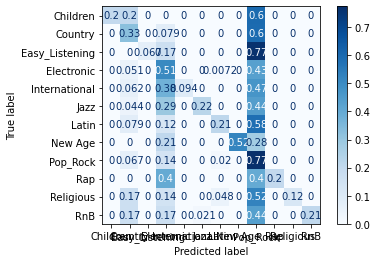

In [23]:
from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

print('\033[1m' + 'RESULTS : \n\n' + 'Classification Report : \n\n'
+ '\033[0m', classification_report(y_test, y_pred), '\n\n' 
+ '\033[1m' + 'Confusion Matrix : \n\n'
+ '\033[0m', confusion_matrix(y_test, y_pred), '\n\n'
+ '\033[1m' + 'Confusion Matrix Percentage : \n\n'
+ '\033[0m', plot_confusion_matrix(clf, K_test, y_test, normalize='true', cmap=plt.cm.Blues, ax=None), '\n\n')


In [39]:
print(list(zip(clf.classes_, clf.predict_proba(K_test)[0])))

[('Children', 0.012205131027441108), ('Country', 0.20351049107679953), ('Easy_Listening', 0.01575394747779128), ('Electronic', 0.03503409543490661), ('International', 0.013373515787642311), ('Jazz', 0.25287724084309715), ('Latin', 0.058912103609958626), ('New Age', 0.0661019398990534), ('Pop_Rock', 0.12437017984345233), ('Rap', 0.11229284148290364), ('Religious', 0.08985061853415385), ('RnB', 0.015717894982800174)]


## Classification via merging disconnected subgraphs into a Big Graph.

Taking the disjoint union for all graphs per datapoint merging in a single big graph for classification via kernels.

In [15]:
import networkx as nx

with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)
y = list()
Gi = dict()
G = list()
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory where graphs where saved
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    key = list(TONNETZEDICT.keys())
    # first check if the directory isn't empty
    if len(os.listdir(graph_directory))>1:
        try: 
            for file in os.listdir(graph_directory):
                IsGraphDir = False
                if file.endswith(key[0] +".p"):
                    Gi[key[0]] = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    IsGraphDir = True
                if file.endswith(key[1] +".p"):
                    Gi[key[1]] = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    IsGraphDir = True
                if file.endswith(key[2] +".p"):
                    Gi[key[2]] = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    IsGraphDir = True
                if file.endswith(key[3] +".p"):
                    Gi[key[3]] = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    IsGraphDir = True
                if file.endswith("label.p"):
                    yi = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    IsGraphDir = True
        except:
            IsGraphDir = False
        # the disjoint union of graphs (have to chek if a graph exists)
        if IsGraphDir:
            U = nx.disjoint_union(Gi["T345"], nx.disjoint_union(Gi["T129"], nx.disjoint_union(Gi["T237"], Gi["T147"])))
            G.append(U)
            y.append(yi)
            IsGraphDir = False

100%|████████████████████████████████████████████████████████████████████████████| 31034/31034 [13:39<00:00, 37.86it/s]


In [17]:
print("We have", len(y), "labels")
print("and", len(G), "graphs")

for label in LABELS+["other"]:
    print('{} has occurred {} times'.format(label, y.count(label)) )

We have 18796 labels
and 18796 graphs
classic has occurred 1392 times
rock has occurred 7402 times
pop has occurred 5140 times
folk has occurred 269 times
metal has occurred 701 times
jazz has occurred 1443 times
disco has occurred 1404 times
other has occurred 1045 times


In [18]:
from sklearn.model_selection import train_test_split
from grakel.utils import graph_from_networkx

# Transform networkx graphs to grakel representations
G = list(graph_from_networkx(G, node_labels_tag='note'))

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.3, shuffle=True, stratify=y)

C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [19]:
from grakel.kernels import WeisfeilerLehman, GraphletSampling
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Uses the WEisfeilerLehman kernel to generate the kernel matrices
gk = WeisfeilerLehman(n_iter=4, normalize=True)
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

Accuracy: 39.48%


### Classification via Boosting

In this section we apply the simple classification for every graph and the descriptors retrieved from the HMD5 files seperately and then we combine the results with a boosting learning algorithm.

In [ ]:
with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)
y = { k : list() for k in TONNETZEDICT.keys()}
G = { k : list() for k in TONNETZEDICT.keys()}
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory where graphs where saved
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    # first check if the directory isn't empty
    if os.listdir(graph_directory):
        for key, tonnetz in TONNETZEDICT.items():
            for file in os.listdir(graph_directory):
                if file.endswith(key +".p"):
                    Gi = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    yi = pickle.load( open( os.path.join(graph_directory, file.split("_graph_" +key+".p")[0]+ "_label.p"), "rb" ) )
                    y[key].append(yi)
                    G[key].append(Gi)

In [ ]:
from sklearn.model_selection import train_test_split
from grakel.kernels import WeisfeilerLehman, GraphletSampling
from sklearn.svm import SVC

G_train = dict()
G_test = dict()
K_train = dict() 
K_test = dict()
clf = dict()
y_pred = dict()

for key in TONNETZEDICT.keys():  
    # Transform networkx graphs to grakel representations
    G[key] = list(graph_from_networkx(G[key], node_labels_tag='note'))
    # do not shuffle the split
    G_train[key], G_test[key], y_train, y_test = train_test_split(G[key], y[key], test_size=0.3, shuffle=False, stratify=y)
    gk = WeisfeilerLehman(n_iter=1, normalize=True)
    K_train[key] = gk.fit_transform(G_train[key])
    K_test[key] = gk.transform(G_test[key])
    y_pred[key] = clf[key].predict(K_test[key])

# Boosting Single Graph Method

In [16]:
from grakel.kernels import WeisfeilerLehman, GraphletSampling
from sklearn.svm import SVC

def singleGraphMethod(SCORE_FILE, LABELS_FILE, Tonnetz):
    with open(SCORE_FILE) as f:
        # The json SCORE_FILE is a dict of ids from Million Dollar
        scores = json.load(f)
    with open(LABELS_FILE) as l:
        labels = json.load(l)
    y = list()
    G = list()
    for msd_id in tqdm(scores.keys()):
        # open every directory with midi files and save file dir to var msd_dir
        msd_dir = msd_id_to_dirs(msd_id)
        # add the directory where graphs where saved
        graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
        # first check if the directory isn't empty and that the msd id is included in the Top-MAGD annotation set
        if msd_id in labels.keys() and os.listdir(graph_directory):
            for file in os.listdir(graph_directory):
                if file.endswith(Tonnetz+".p"):
                    # load descruptors and labels
                    yi = labels[msd_id]
                    Gi = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    y.append(yi)
                    G.append(Gi)
    return (y, G) 

def produce_prediction_vec(G_train, y_train, G_test, y_test):
    # Uses the WEisfeilerLehman kernel to generate the kernel matrices
    gk = WeisfeilerLehman(n_iter=4, normalize=True)
    K_train = gk.fit_transform(G_train)
    K_test = gk.transform(G_test)

    # Uses the SVM classifier to perform classification
    clf = SVC(kernel="precomputed", probability=True)
    clf.fit(K_train, y_train)
    return clf.predict_proba(K_test)

In [17]:
y = dict()
G = dict()
for Tonnetz in TONNETZEDICT.keys():
    y[Tonnetz], G[Tonnetz] = singleGraphMethod(SCORE_FILE, LABELS_FILE, Tonnetz)

100%|██████████████████████████████████████████████████████████████████████████| 31034/31034 [00:05<00:00, 5274.21it/s]


In [18]:
from grakel.utils import graph_from_networkx

y_pred = dict()
for Tonnetz in TONNETZEDICT.keys():
    # Transform networkx graphs to grakel representations
    G[Tonnetz] = list(graph_from_networkx(G[Tonnetz], node_labels_tag='note'))
    G_train = G[Tonnetz][0:4000]
    G_test = G[Tonnetz][4000:]
    y_train = y[Tonnetz][0:4000]
    y_test =  y[Tonnetz][4000:]
    y_pred[Tonnetz] = produce_prediction_vec(G_train, y_train, G_test, y_test)

In [66]:
from sklearn.metrics import accuracy_score

X = np.array(list(zip(y_pred["T345"],y_pred["T237"], y_pred["T129"], y_pred["T147"])))
X = X.reshape((len(X), -1))

clf = SVC()
y_fin_pred = clf.fit(X, y_test).predict(X)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_fin_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

Accuracy: 53.06%
